In [ ]:
'''
【项目07】  城市餐饮店铺选址分析

1、从三个维度“口味”、“人均消费”、“性价比”对不同菜系进行比较，并筛选出可开店铺的餐饮类型
要求：
① 计算出三个维度的指标得分
② 评价方法：
   口味 → 得分越高越好
   性价比 → 得分越高越好
   人均消费 → 价格适中即可
③ 制作散点图，x轴为“人均消费”，y轴为“性价比得分”，点的大小为“口味得分”
   绘制柱状图，分别显示“口味得分”、“性价比得分”
   * 建议用bokeh做图
提示：
① 数据清洗，清除空值、为0的数据
② 口味指标计算方法 → 口味评分字段，按照餐饮类别分组算均值，再做标准化处理
③ 人均消费指标计算方法 → 人均消费字段，按照餐饮类别分组算均值，再做标准化处理
④ 性价比指标计算方法 → 性价比 = （口味 + 环境 + 服务）/人均消费，按照餐饮类别分组算均值，再做标准化处理
⑤ 数据计算之前，检查一下数据分布，去除异常值（以外限为标准）
   * 这里排除了高端奢侈餐饮的数据干扰
⑥ 注意，这里先分别计算三个指标，再合并数据（merge）作图，目的是指标之间的噪音数据不相互影响

2、选择一个餐饮类型，在qgis中做将上海划分成格网空间，结合python辅助做空间指标评价，得到餐饮选址位置
* 课程这里以“素菜馆为例”
课程数据
① net_population.shp → 投影坐标系，上海1km²格网内的人口密度数据
② road.shp → 投影坐标西，上海道路数据
要求：
① 通过空间分析，分别计算每个格网内的几个指标：人口密度指标、道路密度指标、餐饮热度指标、同类竞品指标
② 评价方法：
   人口密度指标 → 得分越高越好
   道路密度指标 → 得分越高越好
   餐饮热度指标 → 得分越高越好
   同类竞品指标 → 得分越低越好
   综合指标 = 人口密度指标*0.4 + 餐饮热度指标*0.3 + 道路密度指标*0.2 +同类竞品指标*0.1
③ 最后得到较好选址的网格位置的中心坐标，以及所属区域
   * 可以用bokeh制作散点图
提示：
① 道路密度指标计算方法 → 网格内道路长度
② 餐饮热度指标计算方法 → 网格内餐饮poi计数
③ 同类竞品指标计算方法 → 网格内素菜馆poi计数
④ 餐饮poi数据记得投影
⑤ 可以以“net_population.shp”为网格基础数据，做空间统计
⑥ 在qgis做空间统计之后，网格数据导出点数据，投影成wgs84地理坐标系，导出excel数据，在python做指标标准化等
⑦ 在bokeh中做散点图时，注意添加一个size字段，通过最终评分来赋值
⑧ 在bokeh中做散点图时，可以给TOP10的点用颜色区分

'''

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 
# 不发出警告
import matplotlib.style as psl
import plotly.express as px
import plotly.graph_objects as go


,口味,口味_norm,人均消费,人均消费_norm,性价比,性价比_norm
类别,,,,,,
素菜,8.021705,1.000000,71.251969,0.365244,0.497415,0.377386
南菜,7.984874,0.948128,90.606557,0.521254,0.317721,0.177197
本菜,7.959824,0.912848,110.673744,0.683007,0.285756,0.141585
火锅,7.949428,0.898206,98.257089,0.582921,0.278237,0.133209
亚菜,7.889937,0.814421,94.674468,0.554043,0.306965,0.165214


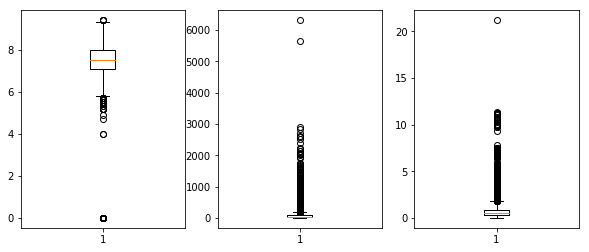

In [29]:
# 1、从三个维度“口味”、“人均消费”、“性价比”对不同菜系进行比较，并筛选出可开店铺的餐饮类型
# 要求：
# ① 计算出三个维度的指标得分
# ② 评价方法：
#    口味 → 得分越高越好
#    性价比 → 得分越高越好
#    人均消费 → 价格适中即可
# ③ 制作散点图，x轴为“人均消费”，y轴为“性价比得分”，点的大小为“口味得分”
#    绘制柱状图，分别显示“口味得分”、“性价比得分”
#    * 建议用bokeh做图
# 提示：
# ① 数据清洗，清除空值、为0的数据
# ② 口味指标计算方法 → 口味评分字段，按照餐饮类别分组算均值，再做标准化处理
# ③ 人均消费指标计算方法 → 人均消费字段，按照餐饮类别分组算均值，再做标准化处理
# ④ 性价比指标计算方法 → 性价比 = （口味 + 环境 + 服务）/人均消费，按照餐饮类别分组算均值，再做标准化处理
# ⑤ 数据计算之前，检查一下数据分布，去除异常值（以外限为标准）
#    * 这里排除了高端奢侈餐饮的数据干扰
# ⑥ 注意，这里先分别计算三个指标，再合并数据（merge）作图，目的是指标之间的噪音数据不相互影响

data = pd.read_excel(r'D:\BaiduNetdiskDownload\项目07城市餐饮店铺选址分析\上海餐饮数据.xlsx',sheet_name='Sheet1')
data.dropna(inplace=True)
data = data[data['人均消费']>0]
data['性价比']=(data['口味']+data['环境']+data['服务'])/data['人均消费']
data.head()
# psl.use('ggplot')
fig,axes=plt.subplots(1,3,figsize=(10,4))
axes[0].boxplot(data['口味'])
axes[1].boxplot(data['人均消费'])
axes[2].boxplot(data['性价比'])
# tast = data.groupby('类别').mean()
def deal_data(data1,col):
    s = data1[col].describe()
    q1 = s.loc['25%']
    q3 = s.loc['75%']
    iqr = q3 - q1
    t1 = q1-3*iqr
    t2 = q3+3*iqr
    return data1[(data1[col]>t1)&(data1[col]<t2)][['类别',col]]
data_kw = deal_data(data,'口味')
data_xf = deal_data(data,'人均消费')
data_xjb = deal_data(data,'性价比')

def st_data(data2,colx):
    col_name = colx + '_norm'
    data_gp = data2.groupby('类别').mean()
    data_gp[col_name] = (data_gp[colx]-data_gp[colx].min())/(data_gp[colx].max()-data_gp[colx].min())
    data_gp.sort_values(by=col_name,inplace=True,ascending=False)
    return data_gp
data_kw_score = st_data(data_kw,'口味')
data_xf_score = st_data(data_xf,'人均消费')
data_xjb_score = st_data(data_xjb,'性价比')

data_final = pd.merge(data_kw_score,data_xf_score,left_index=True,right_index=True)
data_final = pd.merge(data_final,data_xjb_score,left_index=True,right_index=True)
data_final.head()


Text(0.5,1,'各消费区间对比')

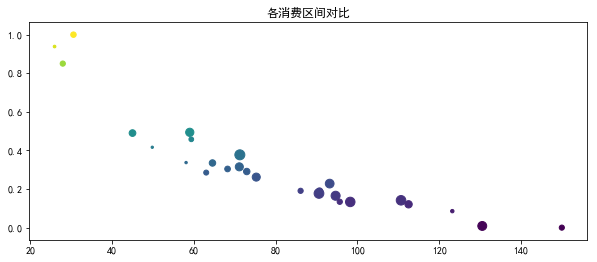

In [99]:
fig,ax=plt.subplots(figsize=(10,4))
plt.rcParams['font.sans-serif']=['SimHei']
ax.scatter(data_final['人均消费'],data_final['性价比_norm'],s=data_final['口味_norm']*100,c=data_final['性价比_norm'],marker='o')
ax.set_title('各消费区间对比')

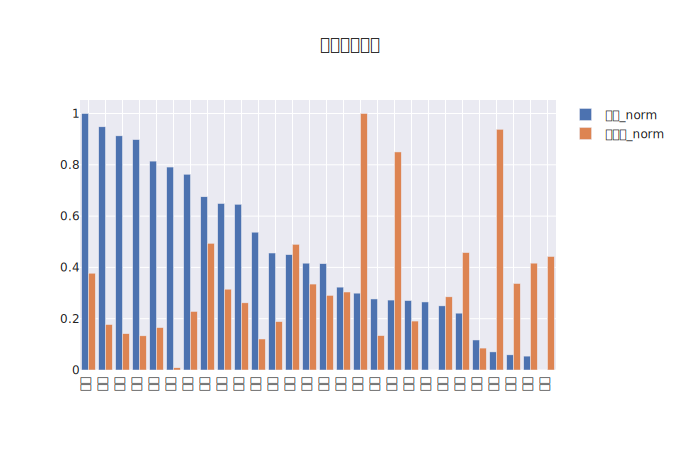

In [96]:
data_final.reset_index(inplace=True,drop=True)
data_final.head()
fig = go.Figure()
# fig = px.bar(data_final,x=data_final['类别'],y=data_final['口味_norm'],template='seaborn')
fig.add_trace(go.Bar(x=data_final['类别'],y=data_final['口味_norm'],name='口味_norm'))
fig.add_trace(go.Bar(x=data_final['类别'],y=data_final['性价比_norm'],name='性价比_norm'))
fig.update_layout(barmode='group',template='seaborn',title='各式菜系对比')
fig.show(renderer='svg')